In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [170]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

Generate stuff for whole team

In [181]:
reload(aps)
team_stats_df = aps.generate_full_team_aggregate( 2017, drop_preseason=False )

In [4]:
print team_stats_df.shape
print team_stats_df.columns.values

(5132, 71)
[u'team' 'opp_team' u'week' 'year' 'score' 'opp_score' 'home_flag'
 'away_flag' 'tds' u'rush_att' u'rush_yds' u'pass_att' u'pass_yds'
 u'pass_cmp' u'pass_sack' u'kickoffs' u'punts' u'fg_miss' u'kickret_tds'
 u'punt_ret_tds' u'off_fumb_tot' u'kickoff_in_20' u'kickoff_touchback'
 u'fg_yds' u'fg_made' u'def_int_tds' u'def_frec_tds' u'def_misc_tds'
 u'def_safety' u'def_tkl' u'def_tkl_contributers' u'def_fumb_rec'
 u'def_fumb_forced' u'def_int' u'def_tkl_loss' u'def_sack' u'def_pass_def'
 'score_prev_4' 'opp_score_prev_4' 'home_flag_prev_4' 'away_flag_prev_4'
 'tds_prev_4' 'rush_att_prev_4' 'rush_yds_prev_4' 'pass_att_prev_4'
 'pass_yds_prev_4' 'pass_cmp_prev_4' 'pass_sack_prev_4' 'kickoffs_prev_4'
 'punts_prev_4' 'fg_miss_prev_4' 'kickret_tds_prev_4' 'punt_ret_tds_prev_4'
 'off_fumb_tot_prev_4' 'kickoff_in_20_prev_4' 'kickoff_touchback_prev_4'
 'fg_yds_prev_4' 'fg_made_prev_4' 'def_int_tds_prev_4'
 'def_frec_tds_prev_4' 'def_misc_tds_prev_4' 'def_safety_prev_4'
 'def_tkl_prev_4'

Defense needs to focus on defensive stats, and some small offensive stats from previous opponents

In [151]:
off_stats = [
                'tds',           # May be useful to keep
                u'rush_att', 
                u'rush_yds',     # May be useful
                u'pass_att', 
                u'pass_yds',     # May be useful
                u'pass_cmp', 
                u'pass_sack', 
                u'kickoffs',
                u'punts', 
                u'fg_miss', 
                u'off_fumb_tot',
                u'kickoff_in_20', 
                u'kickoff_touchback', 
                u'fg_yds', 
                u'fg_made' ]     # May be useful

keep_list = ['team','week','year','includes_preseason','opp_team','opp_score','tds','rush_yds','pass_yds','fg_made']

def_df = team_stats_df[ keep_list ].copy()

In [152]:
# def_frec?
def_stats = [
                u'def_int_tds',          # all_def_tds
                u'def_frec_tds',         # all_def_tds
                u'def_misc_tds' ,        # all_def_tds
                u'def_safety' ,          # def_safety
                u'def_tkl',
                u'def_tkl_contributers', 
                u'def_fumb_forced',
                u'def_fumb_rec',         # all_def_turn
                u'def_int' ,             # all_def_turn
                u'def_tkl_loss',
                u'def_sack' ,            # def_sack
                u'def_pass_def',
                u'kickret_tds',          # all_def_tds
                u'punt_ret_tds'          # all_def_tds
            ]


# All scored the same, hard to predict but can be useful en bulk
def_df['all_def_tds'] = team_stats_df[[
                                        'def_int_tds',
                                        'def_frec_tds',
                                        'def_misc_tds',
                                        'kickret_tds',
                                        'punt_ret_tds'
                                      ]].sum(axis=1)

def_df['all_def_turn'] = team_stats_df[[
                                        'def_fumb_rec',
                                        'def_int'
                                       ]].sum(axis=1)
def_df['def_safety'] = team_stats_df['def_safety']
def_df['def_sack'  ] = team_stats_df['def_sack'  ]

In [153]:
# Aggregate offensive stats are useful, for turning into OPPOSING stats
off_stats2 = [
                'score_prev_4' ,     # opp_
                'opp_score_prev_4' , # def_
                'home_flag_prev_4' , # def_
                'away_flag_prev_4',  # def_
                'tds_prev_4' ,       # opp_
                'rush_att_prev_4' ,
                'rush_yds_prev_4' ,  # opp_
                'pass_att_prev_4',
                'pass_yds_prev_4' ,  # opp_
                'pass_cmp_prev_4' ,
                'pass_sack_prev_4',  # def_
                'kickoffs_prev_4',
                'punts_prev_4' ,
                'fg_miss_prev_4' ,
                'off_fumb_tot_prev_4' ,
                'kickoff_in_20_prev_4' ,
                'kickoff_touchback_prev_4',
                'fg_yds_prev_4' ,
                'fg_made_prev_4'    # opp_
             ]


def_agg = ['opp_score_prev_4','home_flag_prev_4','away_flag_prev_4','pass_sack_prev_4']
opp_agg = ['score_prev_4','tds_prev_4','rush_yds_prev_4','pass_yds_prev_4','fg_made_prev_4']

def_df[def_agg] = team_stats_df[def_agg].copy()
def_df['allowed_points_prev_4'] = def_df['opp_score_prev_4']
def_df = def_df.drop( 'opp_score_prev_4', axis=1 )

a=[
u'prev_opp_score_prev_4',      
u'prev_opp_tds_prev_4',
u'prev_opp_rush_yds_prev_4', 
u'prev_opp_pass_yds_prev_4',
u'prev_opp_fg_made_prev_4',

u'allowed_score_prev_4',
u'allowed_tds_prev_4',  
u'allowed_rush_yds_prev_4',
u'allowed_pass_yds_prev_4',   
u'allowed_fg_made_prev_4',
]

def_df[opp_agg] = team_stats_df[opp_agg].copy()
def_df.rename(columns=dict(zip( opp_agg, ['allowed_'+x for x in opp_agg] )), inplace=True)

In [154]:
# Aggregate is good indicator for team
def_stats2 = [
                'kickret_tds_prev_4', 
                'punt_ret_tds_prev_4',
                'def_int_tds_prev_4',
                'def_frec_tds_prev_4', 
                'def_misc_tds_prev_4', 
                'def_safety_prev_4',
                'def_tkl_prev_4', 
                'def_tkl_contributers_prev_4', 
                'def_fumb_rec_prev_4',
                'def_fumb_forced_prev_4', 
                'def_int_prev_4', 
                'def_tkl_loss_prev_4',
                'def_sack_prev_4', 
                'def_pass_def_prev_4', 
                'includes_preseason'    
             ]

# All scored the same, hard to predict but can be useful en bulk
def_df['all_def_tds_prev_4'] = team_stats_df[[
                                        'def_int_tds_prev_4',
                                        'def_frec_tds_prev_4',
                                        'def_misc_tds_prev_4',
                                        'kickret_tds_prev_4',
                                        'punt_ret_tds_prev_4'
                                      ]].sum(axis=1)

def_df['all_def_turn_prev_4'] = team_stats_df[[
                                        'def_fumb_rec_prev_4',
                                        'def_int_prev_4'
                                       ]].sum(axis=1)
def_df['def_safety_prev_4'] = team_stats_df['def_safety_prev_4']
def_df['def_sack_prev_4'  ] = team_stats_df['def_sack_prev_4'  ]

In [33]:
def_df.head()

,team,week,year,opp_team,tds,rush_yds,pass_yds,fg_made,all_def_tds,all_def_turn,...,allowed_points_prev_4,allowed_score_prev_4,allowed_tds_prev_4,allowed_rush_yds_prev_4,allowed_pass_yds_prev_4,allowed_fg_made_prev_4,all_def_tds_prev_4,all_def_turn_prev_4,def_safety_prev_4,def_sack_prev_4
0,ARI,-3,2009,PIT,1,70,281,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,ARI,-2,2009,SD,0,64,233,2,0,0,...,20.0,10.0,1.0,70.0,281.0,1.0,0.0,0.0,0.0,0.0
2,ARI,-1,2009,GB,5,108,499,1,0,0,...,37.0,16.0,1.0,134.0,514.0,3.0,0.0,0.0,0.0,5.0
3,ARI,0,2009,DEN,0,68,193,0,0,1,...,81.0,53.0,6.0,242.0,1013.0,4.0,0.0,0.0,0.0,7.0
4,ATL,-3,2009,DET,3,113,115,2,1,1,...,111.0,142.0,18.0,469.0,1010.0,6.0,2.0,8.0,0.0,16.0


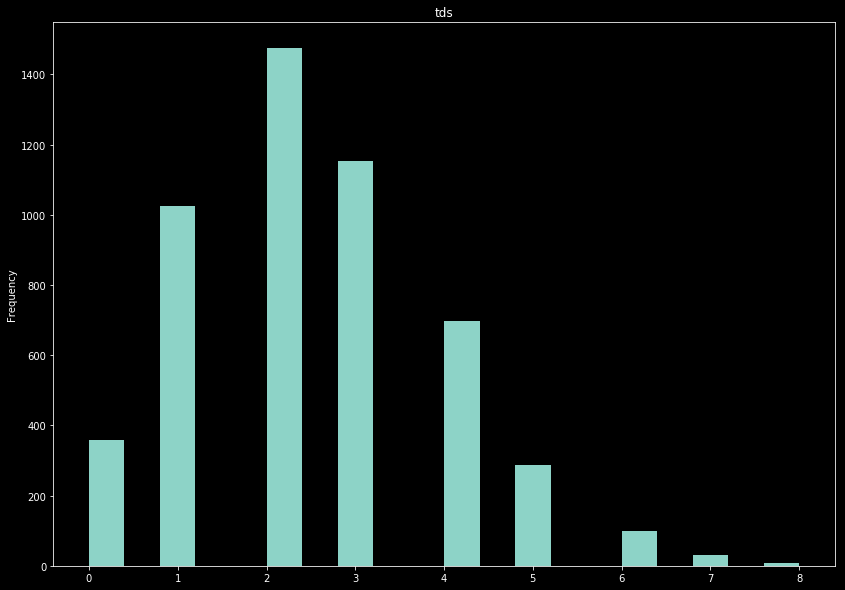

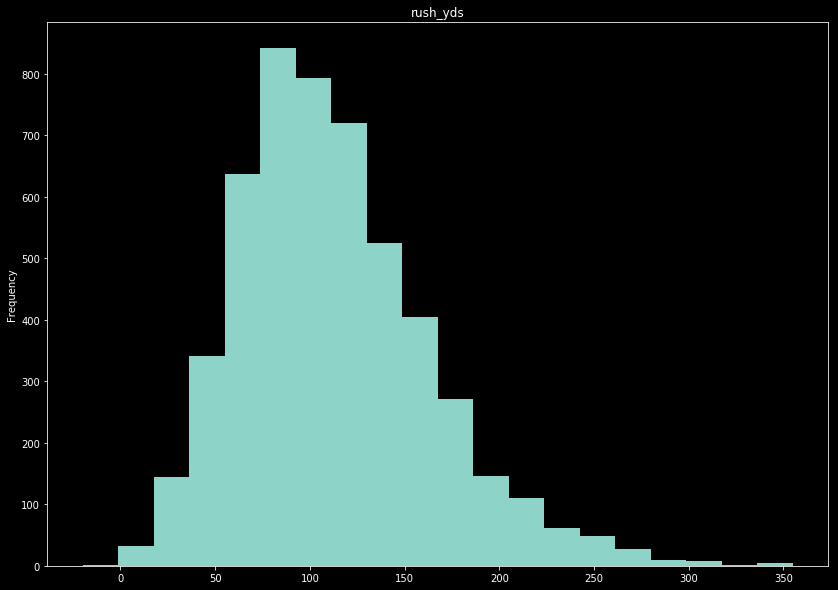

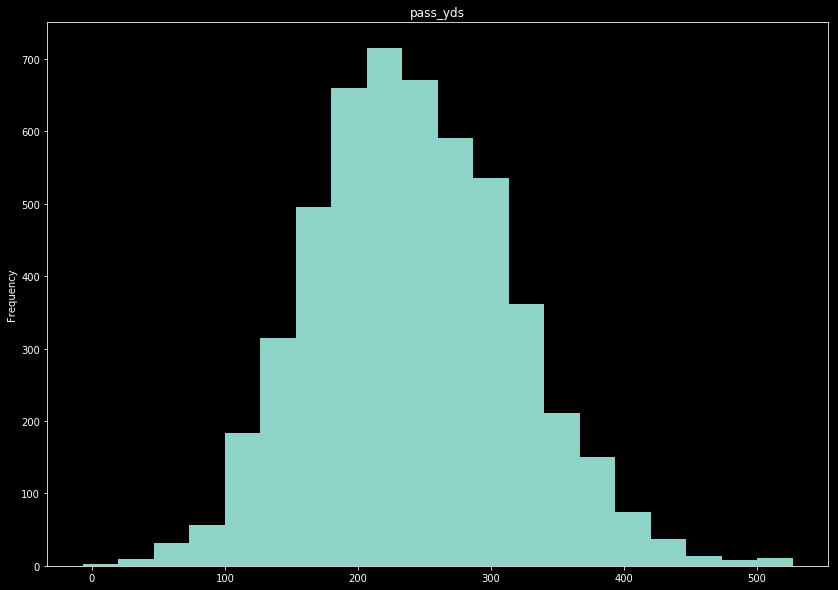

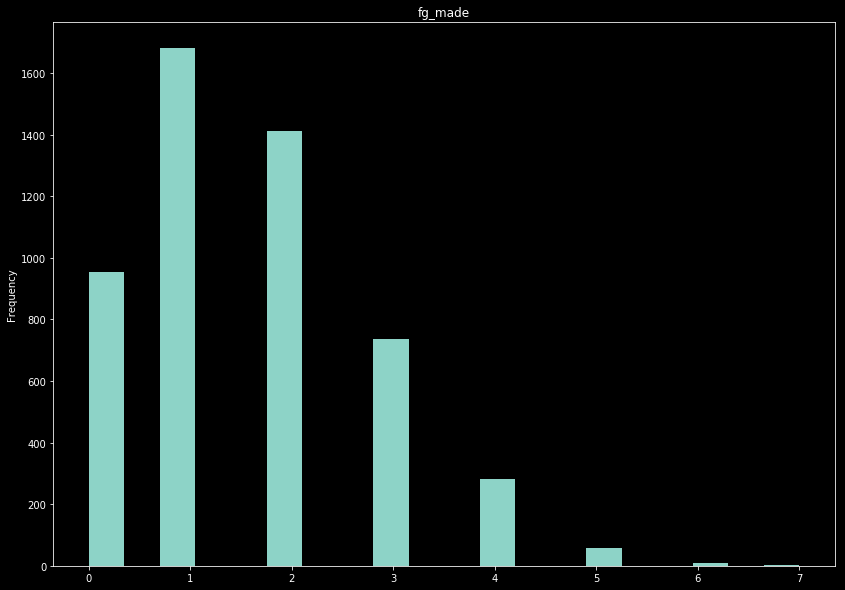

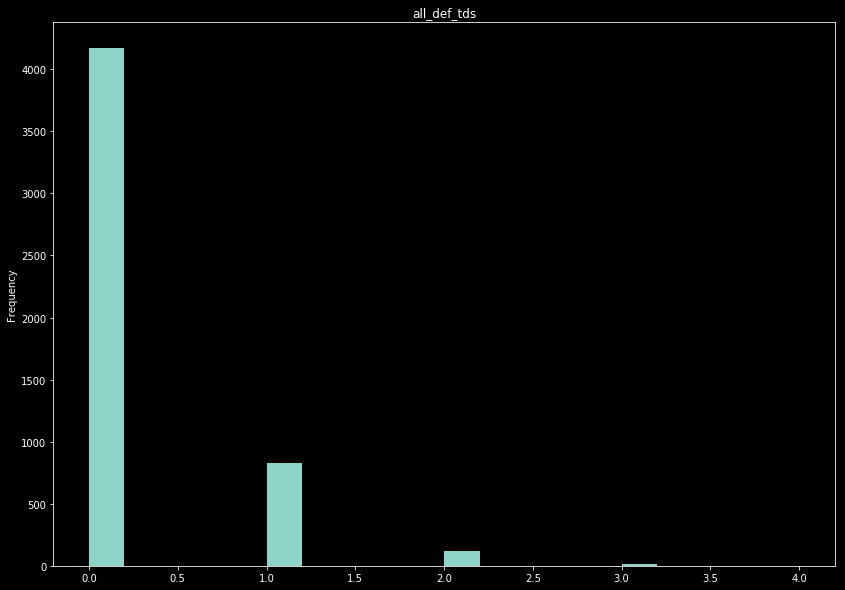

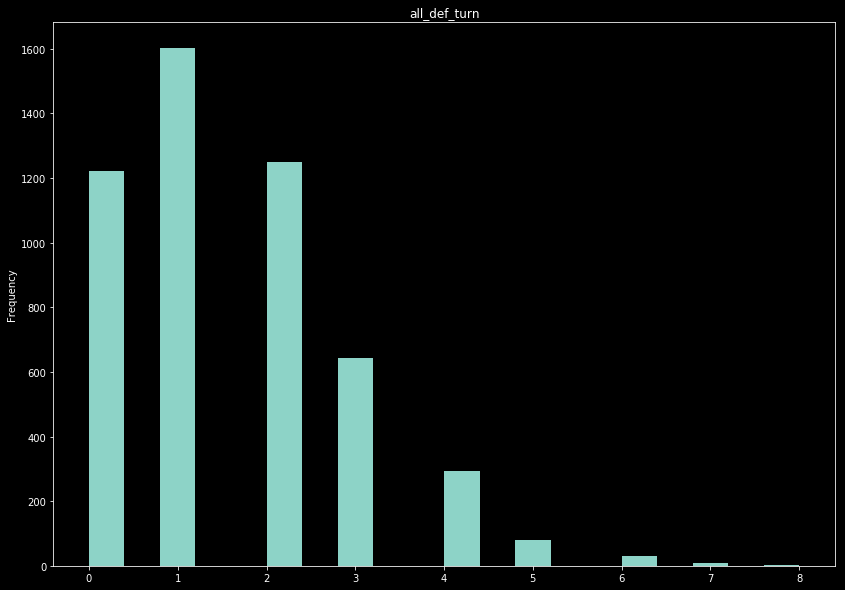

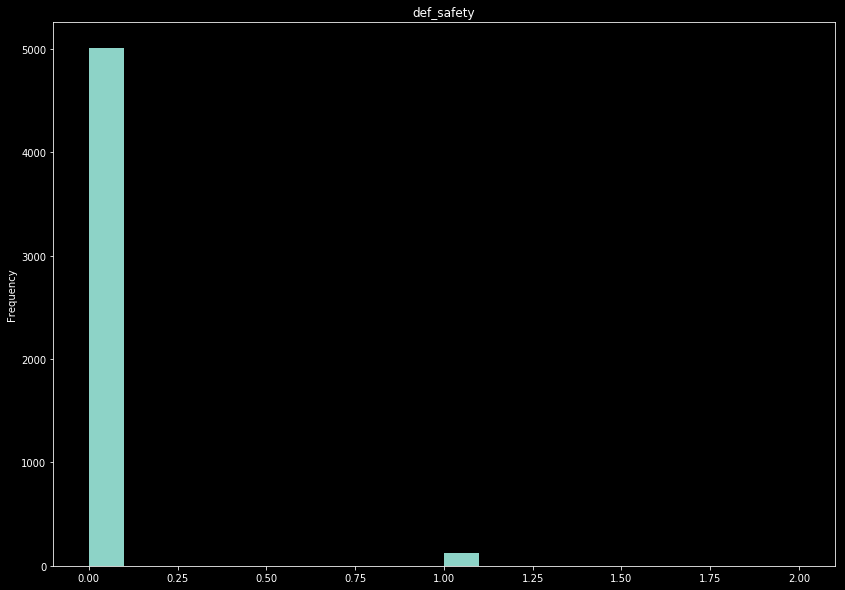

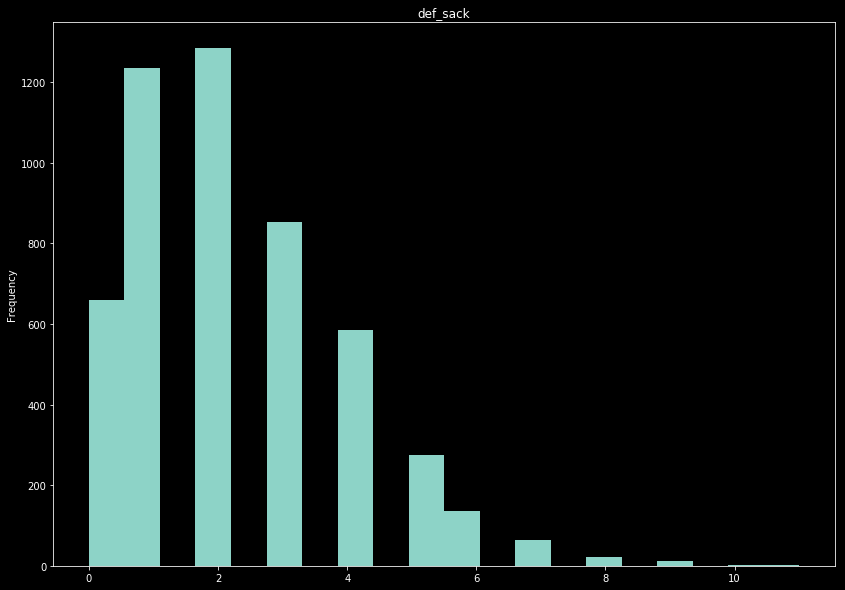

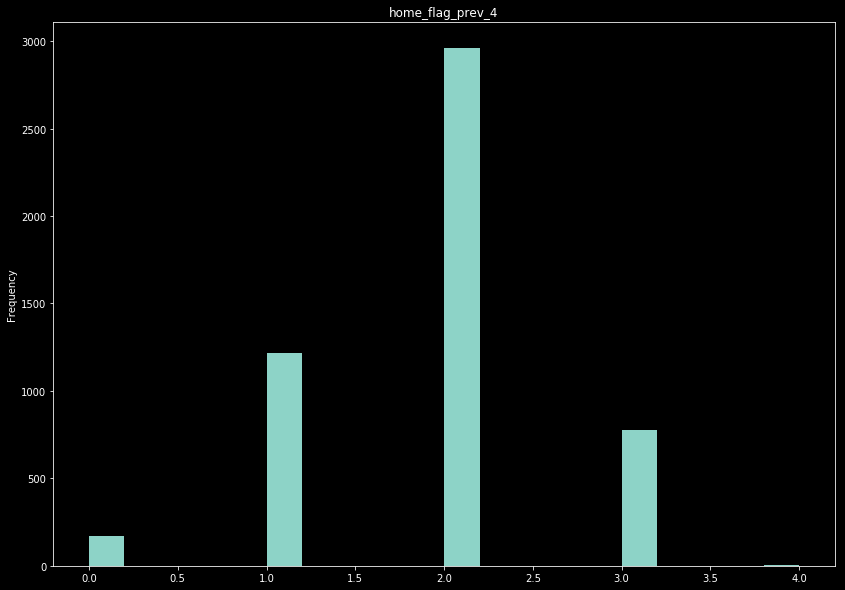

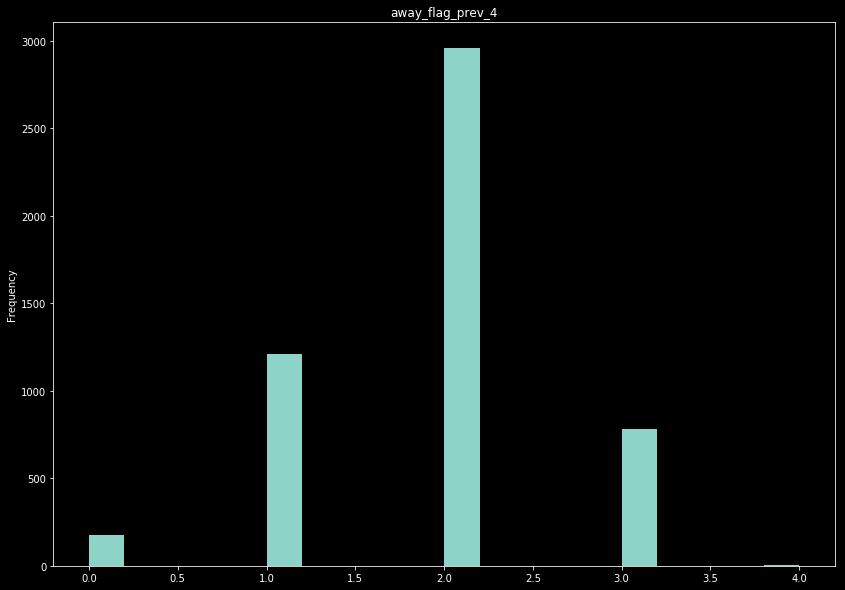

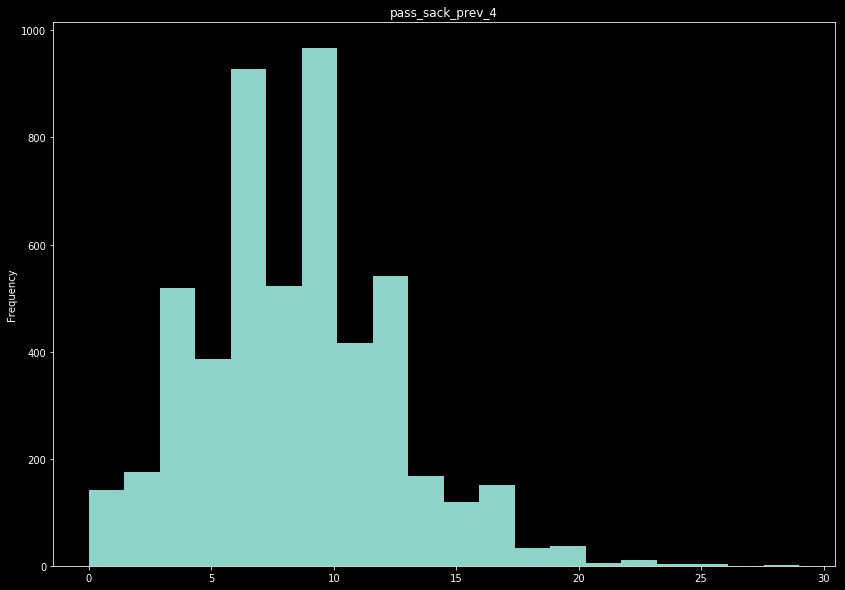

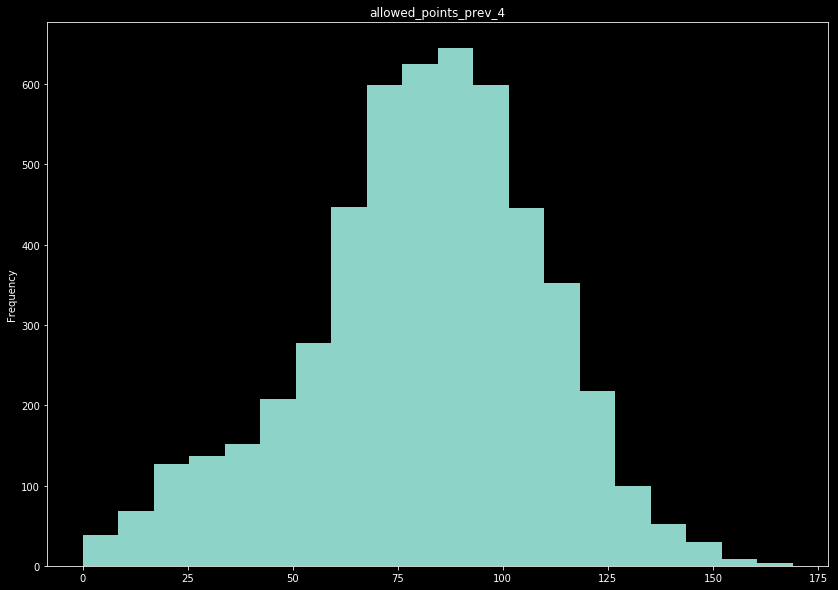

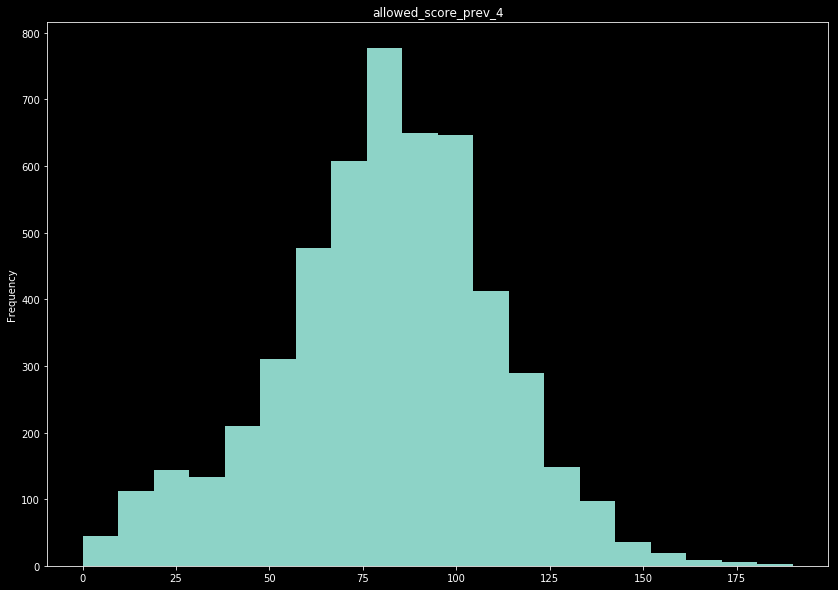

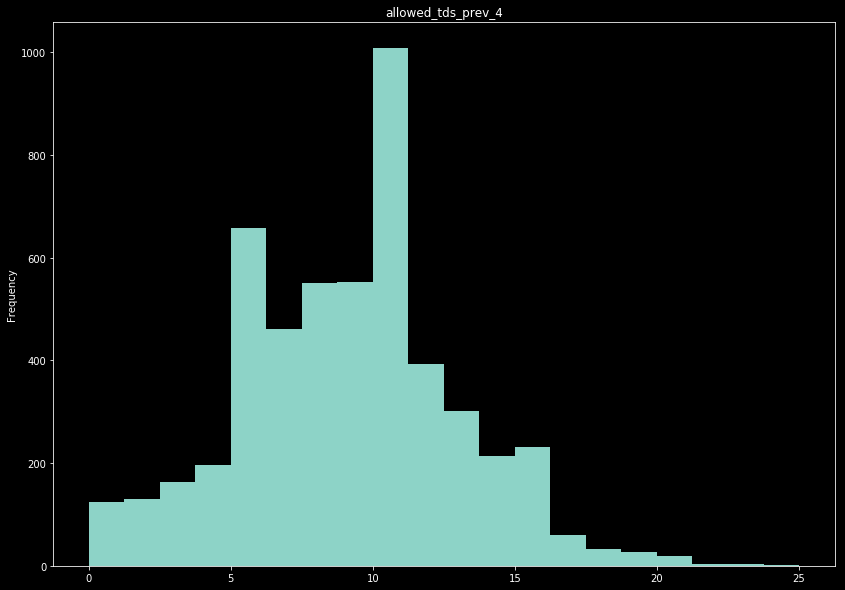

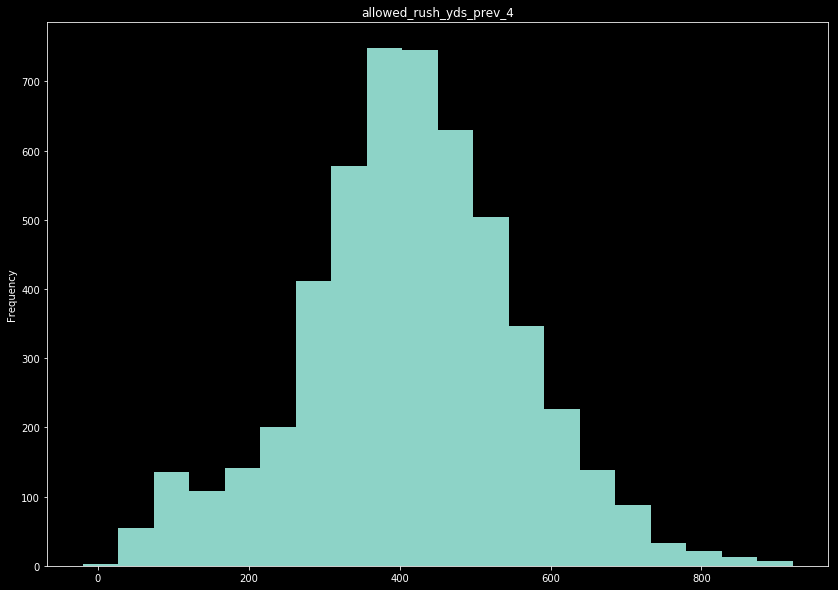

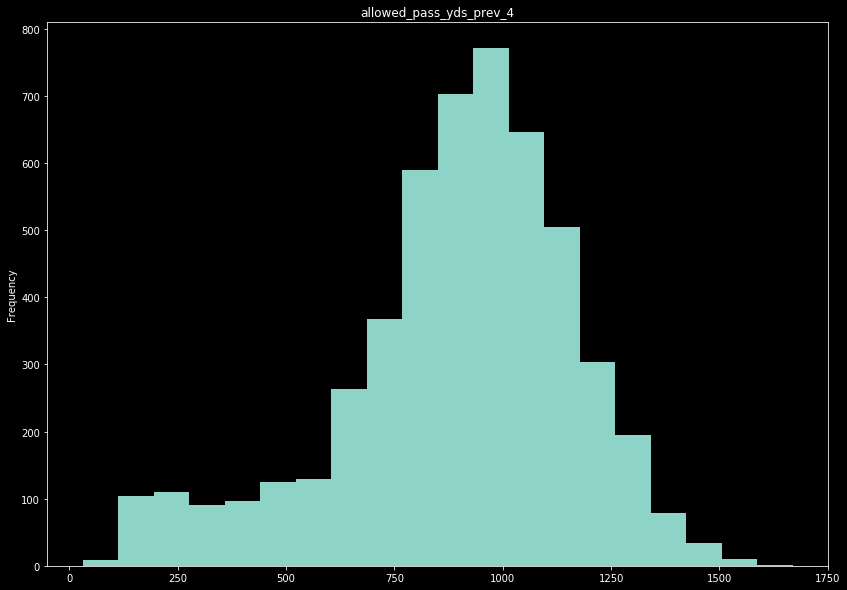

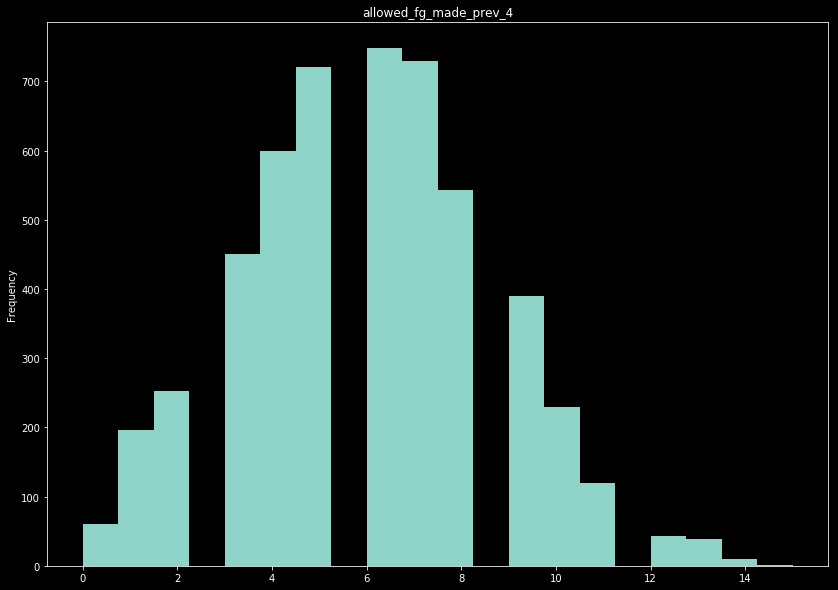

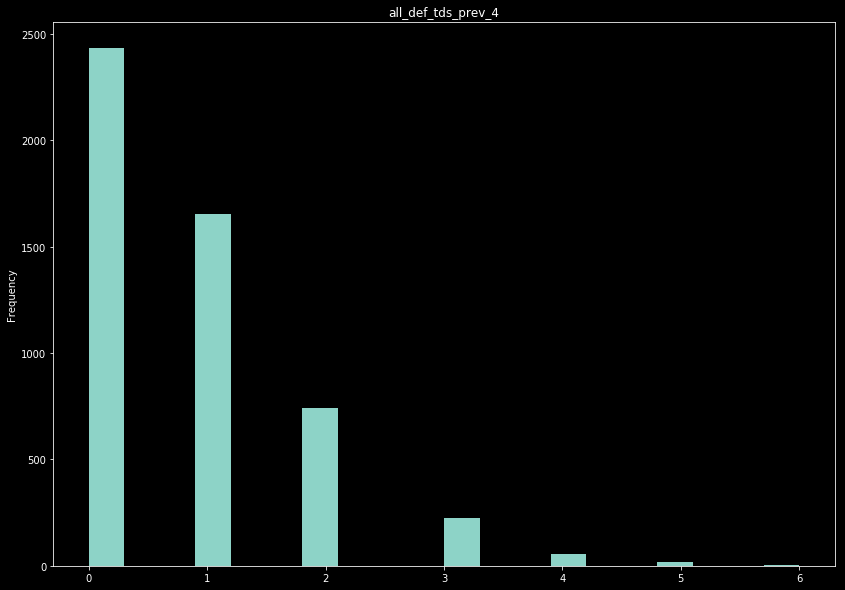

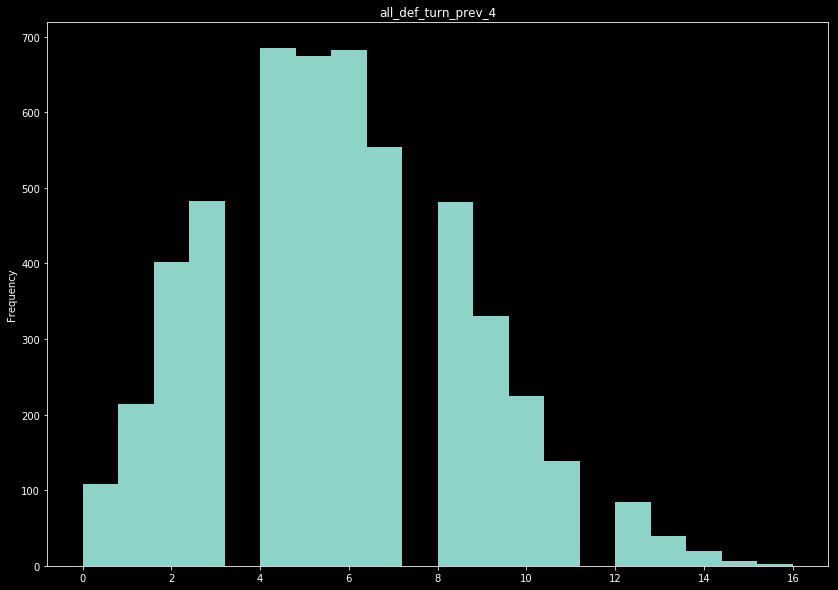

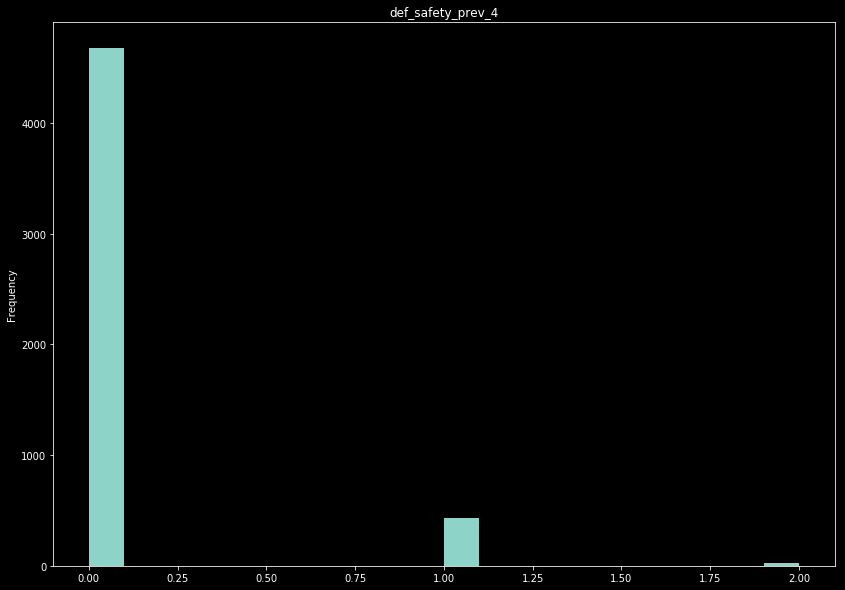

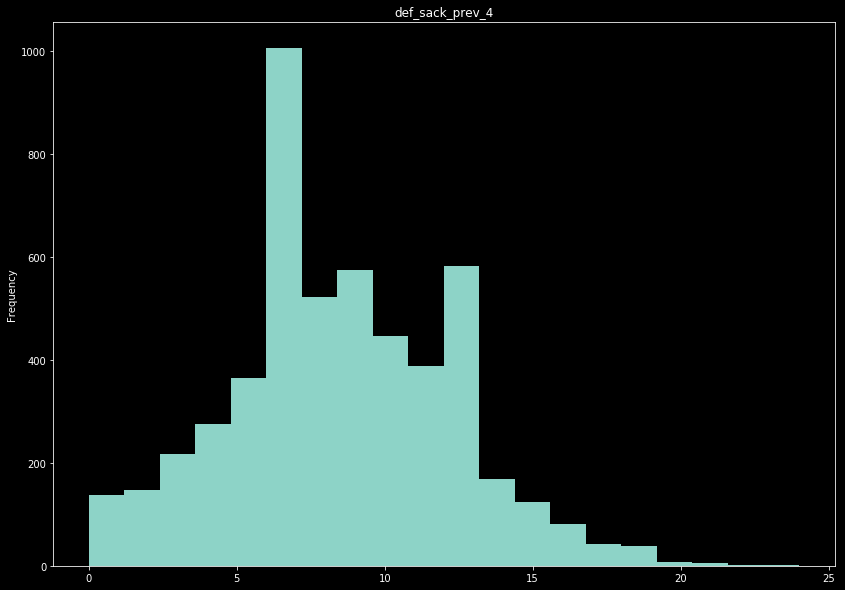

In [34]:
for col in def_df.columns.values[4:]:
    def_df[col].plot.hist(bins=20,title=col)
    plt.show()

Sacks: 1 point.

Interceptions: 2 points.

Fumbles Recovered: 2 points.

Safeties: 2 points.

Defensive Touchdowns: 6 points.

Kick and Punt Return Touchdowns: 6 points.

2-Point Conversion Returns: 2 points.

Points Allowed (0): 10 points

Points Allowed (1-6): 7 points

Points Allowed (7-13): 4 points

Points Allowed (14-20): 1 points

Points Allowed (21-27): 0 points

Points Allowed (28-34): -1 points

Points Allowed (35+): -4 points

In [35]:
def_df.columns

Index([                   u'team',                    u'week',
                          u'year',                u'opp_team',
                           u'tds',                u'rush_yds',
                      u'pass_yds',                 u'fg_made',
                   u'all_def_tds',            u'all_def_turn',
                    u'def_safety',                u'def_sack',
              u'home_flag_prev_4',        u'away_flag_prev_4',
              u'pass_sack_prev_4',   u'allowed_points_prev_4',
          u'allowed_score_prev_4',      u'allowed_tds_prev_4',
       u'allowed_rush_yds_prev_4', u'allowed_pass_yds_prev_4',
        u'allowed_fg_made_prev_4',      u'all_def_tds_prev_4',
           u'all_def_turn_prev_4',       u'def_safety_prev_4',
               u'def_sack_prev_4'],
      dtype='object')

In [29]:
# Off stats are useless? tds, rush_yds, pass_yds, fg_made
# Leave home/away_flags, make a count/discreet continuous

# Target variables are: all_def_tds, all_def_turn, def_safety, def_sack, allowed_points

# Features: 'all_def_tds_prev_4', 'all_def_turn_prev_4', 'def_safety_prev_4', 'def_sack_prev_4', points_allowed_prev_4

In [155]:
# Current 'allowed_' are for the current team, need to turn these into averages for past 4
#  and then average over previous four opponents

n_weeks = 4
wk_str  = str(n_weeks)


other_team_list = ['allowed_tds_prev_4', 'allowed_rush_yds_prev_4', 'allowed_pass_yds_prev_4', 'allowed_fg_made_prev_4']

foo = def_df[ ['team','opp_team','week','year'] ].copy()

foo['opp_avg'+wk_str+'_tds'     ] = def_df['allowed_tds_prev_'     +wk_str]
foo['opp_avg'+wk_str+'_rush_yds'] = def_df['allowed_rush_yds_prev_'+wk_str] 
foo['opp_avg'+wk_str+'_pass_yds'] = def_df['allowed_pass_yds_prev_'+wk_str] 
foo['opp_avg'+wk_str+'_fg_made' ] = def_df['allowed_fg_made_prev_' +wk_str] 


# Bar contains averages of an individual team's  
#  values over previous games, for different opponents
foo =(aps.calc_prev_team_stats( foo, 
                            foo.columns.values[4:], 
                            avg_cols=foo.columns.values[4:] )
                          [
                            [
                                'team',
                                'week',
                                'year',
                                'opp_avg'+wk_str+'_tds_avg_'     +wk_str,
                                'opp_avg'+wk_str+'_rush_yds_avg_'+wk_str,
                                'opp_avg'+wk_str+'_pass_yds_avg_'+wk_str,
                                'opp_avg'+wk_str+'_fg_made_avg_' +wk_str
                            ]
                          ]
    )

# Rename bar columns
foo.columns =  [
                    'team',
                    'week',
                    'year',
                    'opp_avg'+wk_str+'_tds',
                    'opp_avg'+wk_str+'_rush_yds',
                    'opp_avg'+wk_str+'_pass_yds',
                    'opp_avg'+wk_str+'_fg_made'
               ]


# Need to average bar over teams faced,
#  so consider teams faced, join team with opp team
#  then avg the opp team over past 4 games

# Do the joining on opposing team
bar =(pd.merge( def_df[['team','opp_team','week','year']], 
                foo, 
                left_on =['opp_team','week','year'], 
                right_on=[    'team','week','year'])
                .drop( 'team_y', axis=1 )
                .rename( index=str, columns={'team_x':'team'} )
     )

# Perform aggregation, so sums opposing team allowed yardage
#  for a given team
bar = aps.calc_prev_team_stats( bar, bar.columns.values[4:] )

In [29]:
# Off stats are useless? tds, rush_yds, pass_yds, fg_made
# Leave home/away_flags, make a count/discreet continuous

# Target variables are: all_def_tds, all_def_turn, def_safety, def_sack, allowed_points

# Features: 'all_def_tds_prev_4', 'all_def_turn_prev_4', 'def_safety_prev_4', 'def_sack_prev_4', points_allowed_prev_4

In [159]:
use_df = def_df[['team','week','year','includes_preseason']].copy()

# Targets
for col in ['all_def_tds', 
            'all_def_turn', 
            'def_safety', 
            'def_sack']:
    use_df[col] = def_df[col].copy()

# Opposing team's score
use_df['allowed_points'] = def_df['opp_score']



# Features
use_df['home_frac_prev_4'] = def_df['home_flag_prev_4'] / ( def_df['home_flag_prev_4'] + 0.0 + def_df['away_flag_prev_4'] )


# Aggregate features
for col in ['all_def_tds_prev_4',
            'all_def_turn_prev_4',
            'def_safety_prev_4',
            'def_sack_prev_4',
            'allowed_points_prev_4']:
    use_df[col] = def_df[col].copy()

# Combine with what the defenses allowed in the previous games
#  against opposing teams, on average
use_df = pd.merge( 
                    use_df, 
                    bar,
                    on=['team','year','week']
                 )

# Only select regular season
use_df = use_df.loc[ use_df['week']>0 ]

In [160]:
use_df.head()

,team,week,year,includes_preseason,all_def_tds,all_def_turn,def_safety,def_sack,allowed_points,home_frac_prev_4,all_def_tds_prev_4,all_def_turn_prev_4,def_safety_prev_4,def_sack_prev_4,allowed_points_prev_4,opp_avg4_tds_prev_4,opp_avg4_rush_yds_prev_4,opp_avg4_pass_yds_prev_4,opp_avg4_fg_made_prev_4
1036,ARI,1,2009,0,0,1,0,3.0,20.0,0.50,0.0,1.0,0.0,9.0,100.0,29.50,1499.166667,3228.25,22.083333
1037,ARI,2,2009,0,1,3,0,4.0,17.0,0.75,0.0,2.0,0.0,12.0,100.0,27.50,1449.666667,2726.75,19.333333
1038,ARI,3,2009,0,0,1,0,0.0,31.0,0.50,1.0,5.0,0.0,11.0,100.0,19.75,1080.166667,2290.00,16.333333
1039,ARI,5,2009,0,1,1,0,0.0,21.0,0.50,1.0,6.0,0.0,9.0,87.0,19.25,1011.666667,2369.50,17.833333
1040,ARI,6,2009,0,0,2,0,5.0,3.0,0.75,2.0,6.0,0.0,7.0,89.0,22.75,1034.250000,2832.00,19.250000


In [164]:
# Need to fix "includes_preseason", only a few properly flagged

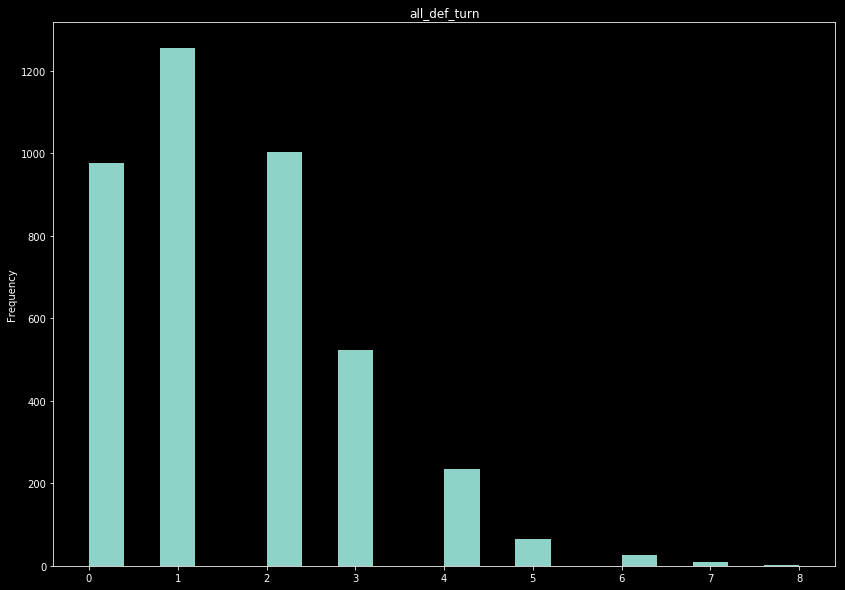

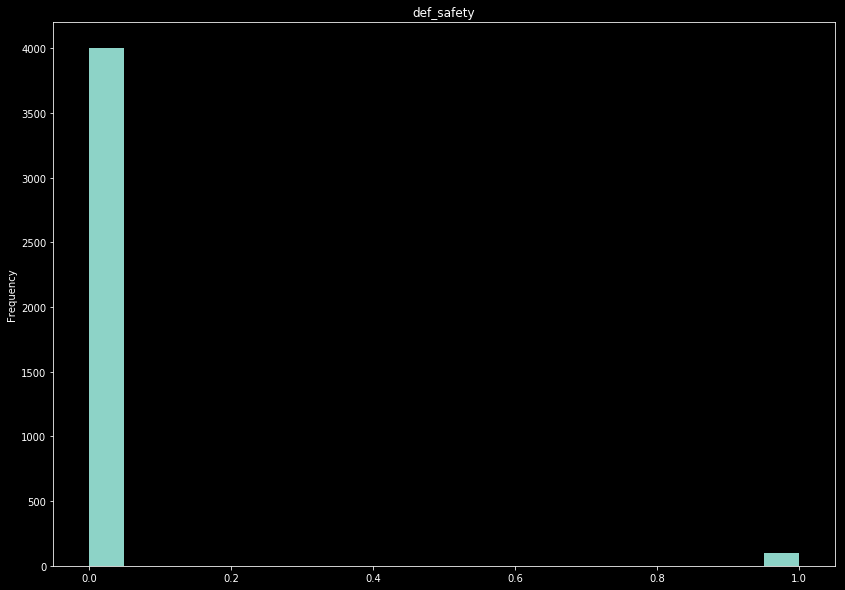

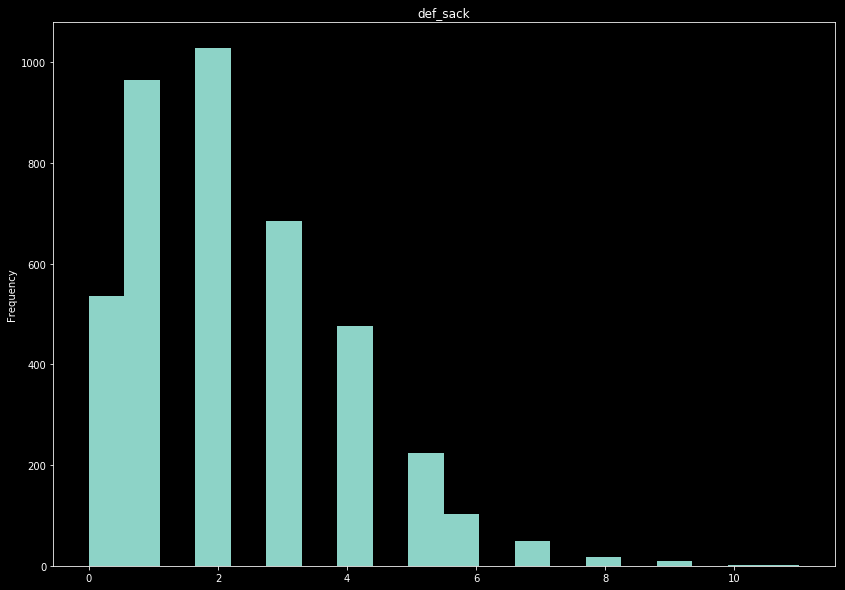

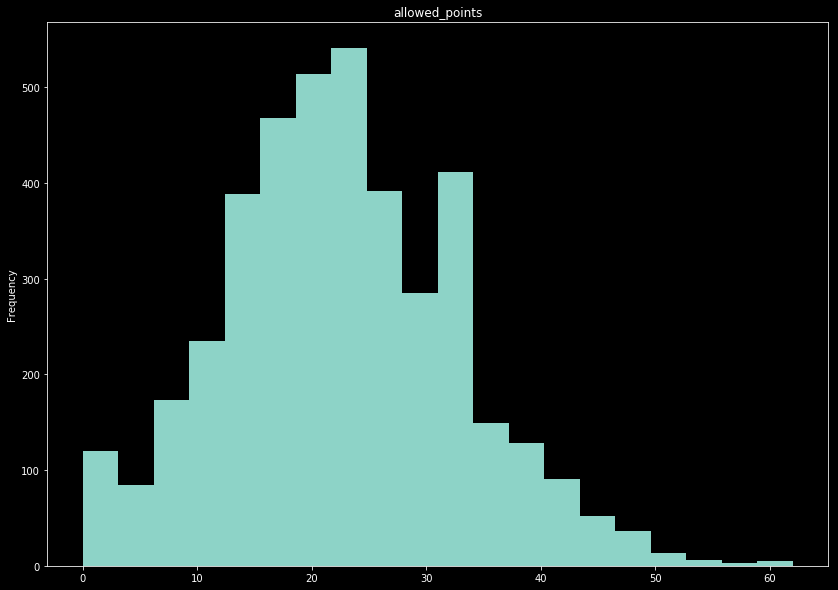

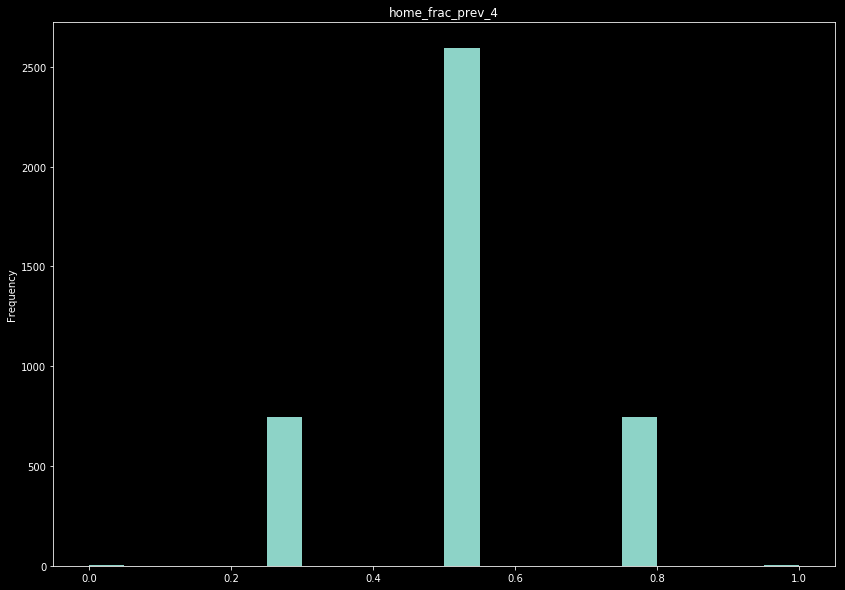

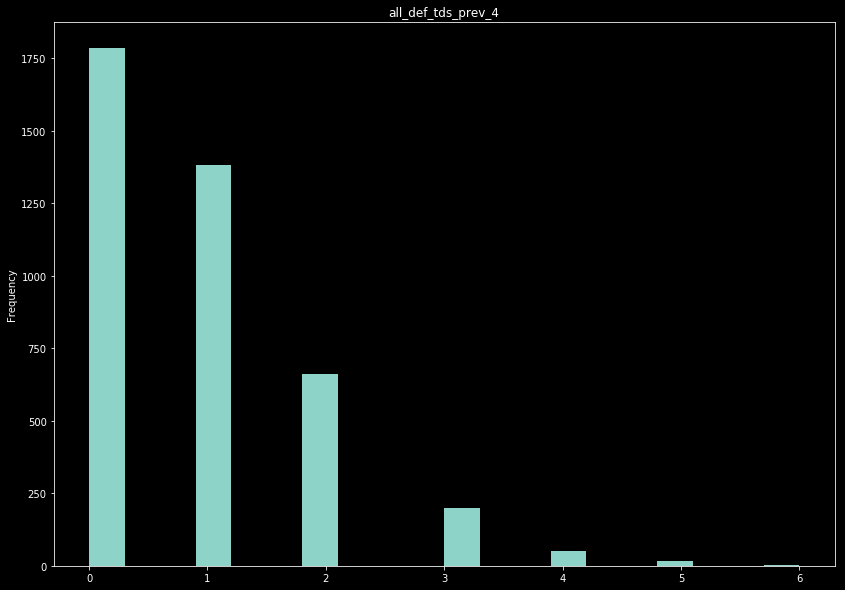

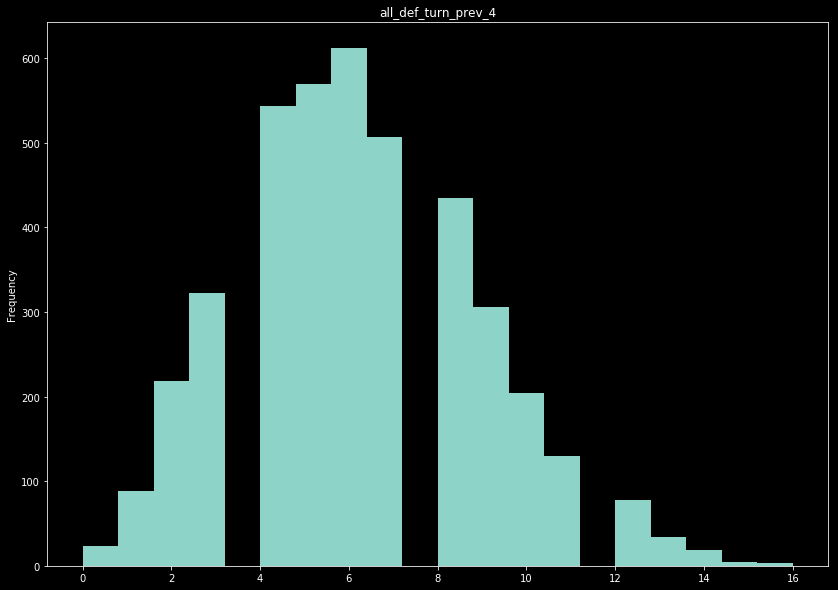

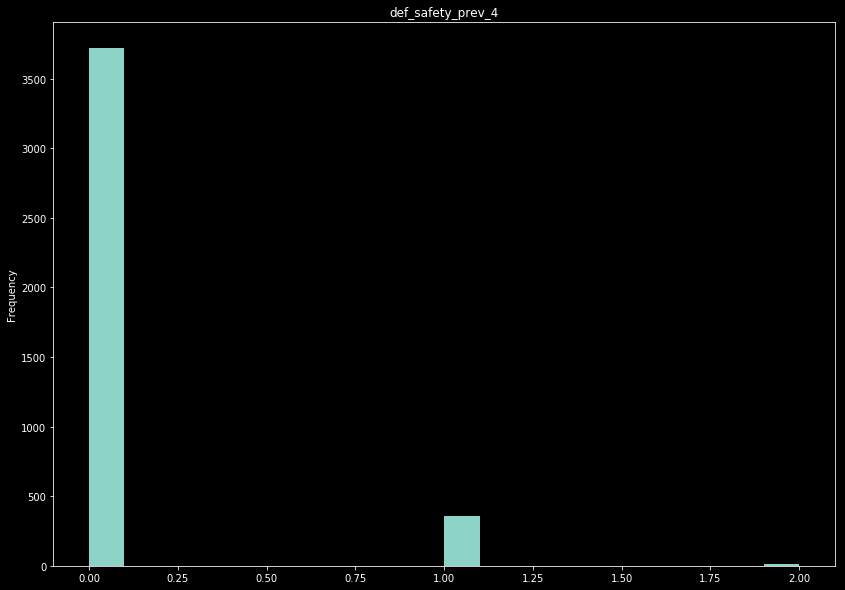

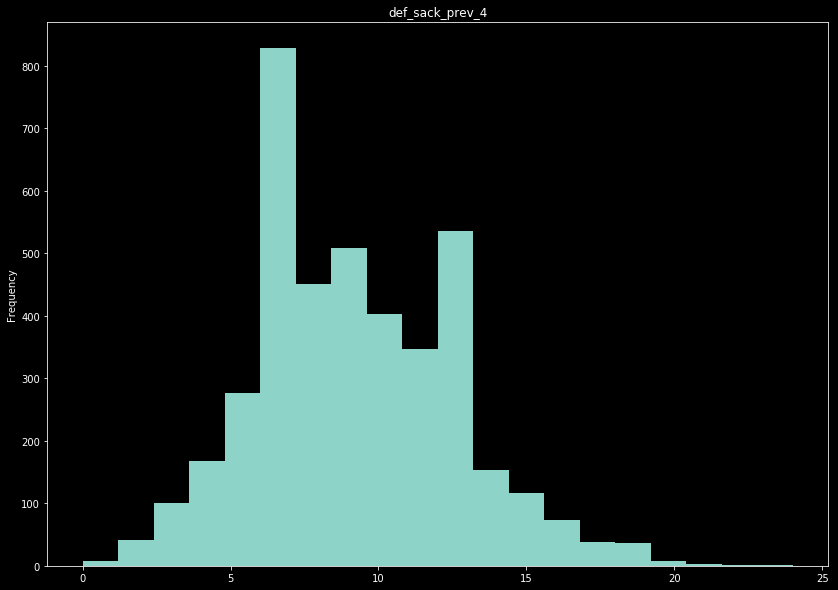

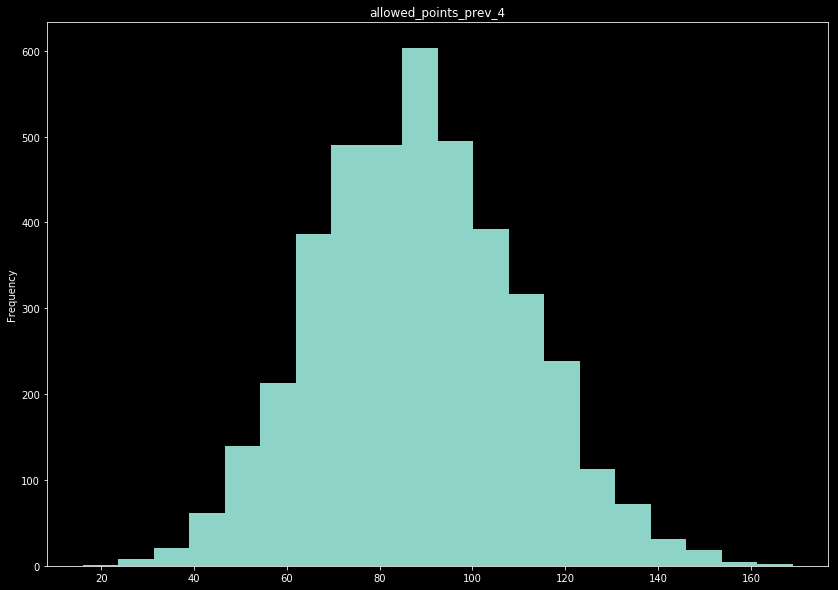

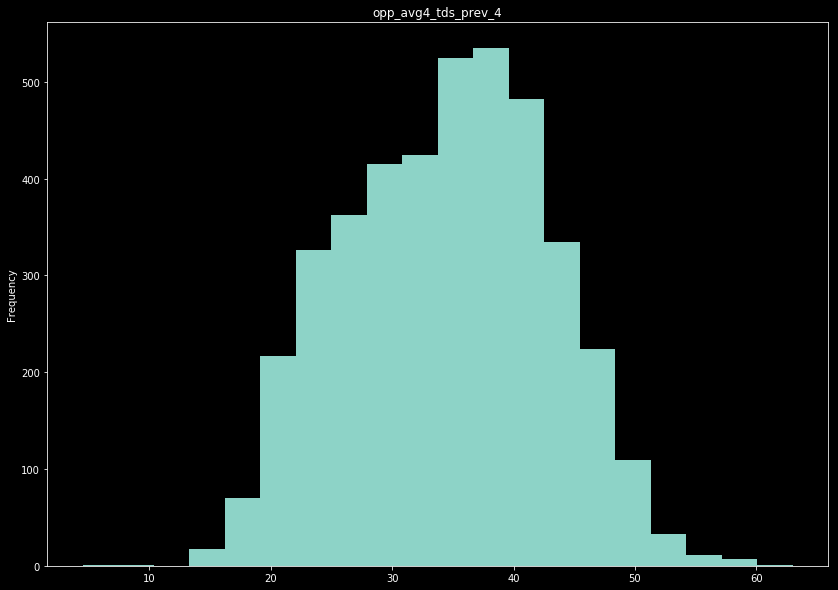

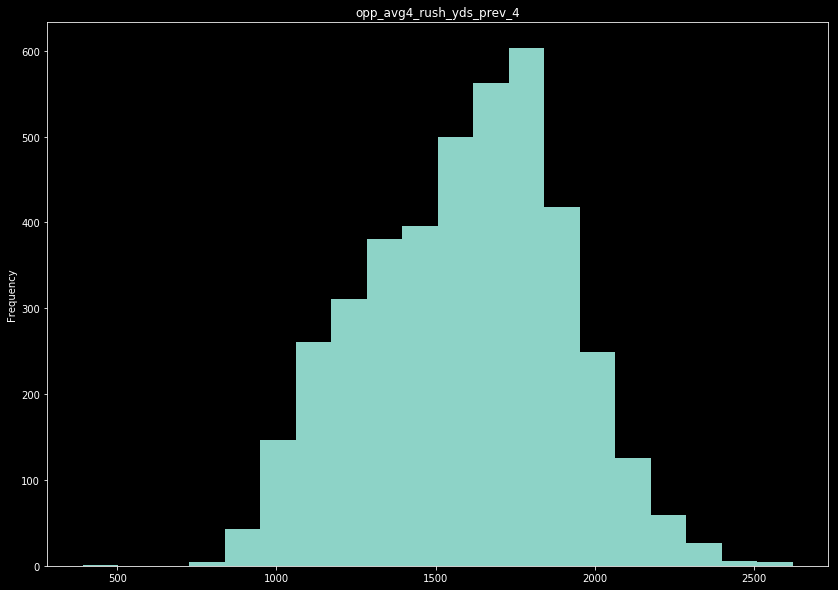

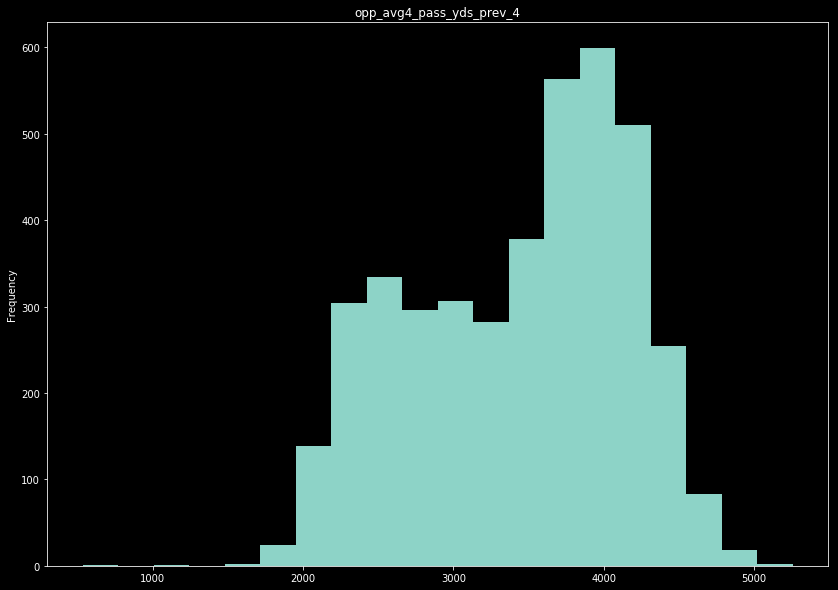

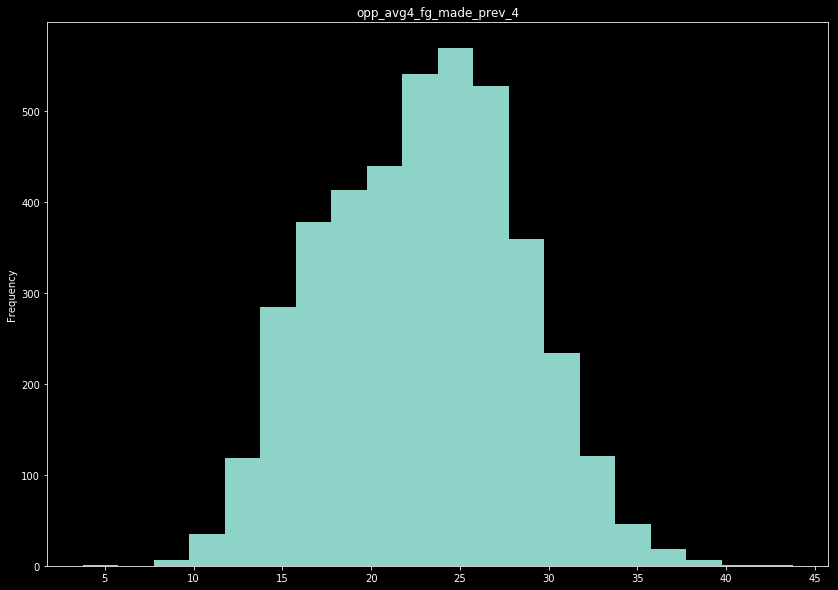

In [165]:
for col in use_df.columns.values[5:]:
    use_df[col].plot.hist( bins=20, title=col )
    plt.show()

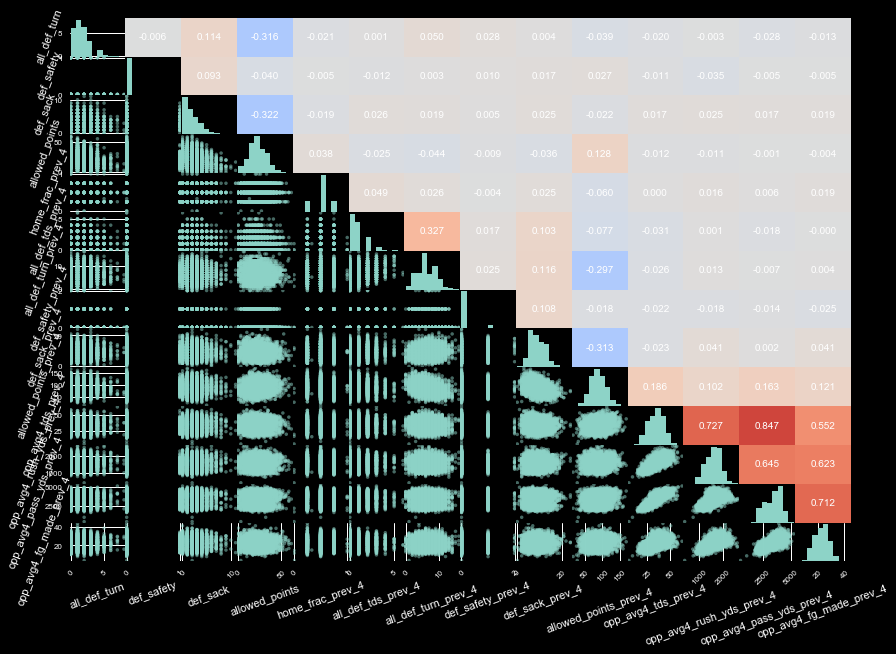

In [171]:
import df_visualizations as dv

dv.corr_plot( use_df[ use_df.columns.values[5:]] )

In [183]:
# Generates the defensive features
# Mostly reliant of team stats, including
#  how previous teams performed against
#  this team in the past
def generate_def_features( end_year, n_weeks=4, start_year=2009 ):


    wk_str  = str(n_weeks)

    team_stats_df = aps.generate_full_team_aggregate( end_year,
                                                      n_weeks,
                                                      start_year,
                                                      drop_preseason=False )

    keep_list = ['team','week','year','includes_preseason',
                 'opp_team','opp_score','tds',
                 'rush_yds','pass_yds','fg_made']

    def_df = team_stats_df[ keep_list ].copy()

    # All scored the same, hard to predict individually
    #  but can likely predict def scores as a whole
    def_df['all_def_tds'] = team_stats_df[[
                                            'def_int_tds',
                                            'def_frec_tds',
                                            'def_misc_tds',
                                            'kickret_tds',
                                            'punt_ret_tds'
                                          ]].sum(axis=1)

    # Same thing with turnovers
    def_df['all_def_turn'] = team_stats_df[[
                                            'def_fumb_rec',
                                            'def_int'
                                           ]].sum(axis=1)

    # Extremely rare
    def_df['def_safety'] = team_stats_df['def_safety']

    def_df['def_sack'  ] = team_stats_df['def_sack'  ]


    def_agg = ['opp_score_prev_4','home_flag_prev_4','away_flag_prev_4','pass_sack_prev_4']
    opp_agg = ['score_prev_4','tds_prev_4','rush_yds_prev_4','pass_yds_prev_4','fg_made_prev_4']

    def_df[def_agg] = team_stats_df[def_agg].copy()
    def_df['allowed_points_prev_4'] = def_df['opp_score_prev_4']
    def_df = def_df.drop( 'opp_score_prev_4', axis=1 )

    def_df[opp_agg] = team_stats_df[opp_agg].copy()
    def_df.rename(columns=dict(zip( opp_agg, ['allowed_'+x for x in opp_agg] )), inplace=True)


    # Aggregate some of the above

    # Prob good indicators
    def_df['all_def_tds_prev_4'] = team_stats_df[[
                                            'def_int_tds_prev_4',
                                            'def_frec_tds_prev_4',
                                            'def_misc_tds_prev_4',
                                            'kickret_tds_prev_4',
                                            'punt_ret_tds_prev_4'
                                          ]].sum(axis=1)

    def_df['all_def_turn_prev_4'] = team_stats_df[[
                                            'def_fumb_rec_prev_4',
                                            'def_int_prev_4'
                                           ]].sum(axis=1)

    def_df['def_safety_prev_4'] = team_stats_df['def_safety_prev_4']
    def_df['def_sack_prev_4'  ] = team_stats_df['def_sack_prev_4'  ]




    # Current 'allowed_' are for the current team and one game, 
    #  need to turn these into averages for past 4,
    #  and then average over previous four opponents



    other_team_list = ['allowed_tds_prev_4', 'allowed_rush_yds_prev_4', 'allowed_pass_yds_prev_4', 'allowed_fg_made_prev_4']

    foo = def_df[ ['team','opp_team','week','year'] ].copy()

    foo['opp_avg'+wk_str+'_tds'     ] = def_df['allowed_tds_prev_'     +wk_str]
    foo['opp_avg'+wk_str+'_rush_yds'] = def_df['allowed_rush_yds_prev_'+wk_str] 
    foo['opp_avg'+wk_str+'_pass_yds'] = def_df['allowed_pass_yds_prev_'+wk_str] 
    foo['opp_avg'+wk_str+'_fg_made' ] = def_df['allowed_fg_made_prev_' +wk_str] 


    # Foo will contain averages of an individual team's  
    #  values over previous games, for different opponents
    foo =(aps.calc_prev_team_stats( foo, 
                                foo.columns.values[4:], 
                                avg_cols=foo.columns.values[4:] )
                              [
                                [
                                    'team',
                                    'week',
                                    'year',
                                    'opp_avg'+wk_str+'_tds_avg_'     +wk_str,
                                    'opp_avg'+wk_str+'_rush_yds_avg_'+wk_str,
                                    'opp_avg'+wk_str+'_pass_yds_avg_'+wk_str,
                                    'opp_avg'+wk_str+'_fg_made_avg_' +wk_str
                                ]
                              ]
        )

    # Rename foo columns
    foo.columns =  [
                        'team',
                        'week',
                        'year',
                        'opp_avg'+wk_str+'_tds',
                        'opp_avg'+wk_str+'_rush_yds',
                        'opp_avg'+wk_str+'_pass_yds',
                        'opp_avg'+wk_str+'_fg_made'
                   ]


    # Need to average foo over teams faced,
    #  so consider teams faced, join team with opp team
    #  then avg the opp team over past 4 games

    # Do the joining on opposing team
    bar =(pd.merge( def_df[['team','opp_team','week','year']], 
                    foo, 
                    left_on =['opp_team','week','year'], 
                    right_on=[    'team','week','year'])
                    .drop( 'team_y', axis=1 )
                    .rename( index=str, columns={'team_x':'team'} )
         )

    # Perform aggregation, so sums opposing team allowed yardage
    #  for a given team
    bar = aps.calc_prev_team_stats( bar, bar.columns.values[4:] )



    use_df = def_df[['team','week','year','includes_preseason']].copy()

    # Targets
    for col in ['all_def_tds', 
                'all_def_turn', 
                'def_safety', 
                'def_sack']:
        use_df[col] = def_df[col].copy()

    # Opposing team's score
    use_df['allowed_points'] = def_df['opp_score']



    # Features
    use_df['home_frac_prev_4'] = def_df['home_flag_prev_4'] / ( def_df['home_flag_prev_4'] + 0.0 + def_df['away_flag_prev_4'] )


    # Aggregate features
    for col in ['all_def_tds_prev_4',
                'all_def_turn_prev_4',
                'def_safety_prev_4',
                'def_sack_prev_4',
                'allowed_points_prev_4']:
        use_df[col] = def_df[col].copy()

    # Combine with what the defenses allowed in the previous games
    #  against opposing teams, on average
    use_df = pd.merge( 
                        use_df, 
                        bar,
                        on=['team','year','week']
                     )

    # Only select regular season
    use_df = use_df.loc[ use_df['week']>0 ]
    
    return use_df.copy()

In [184]:
use2 = generate_def_features( 2017 )

In [185]:
use2.head()

,team,week,year,includes_preseason,all_def_tds,all_def_turn,def_safety,def_sack,allowed_points,home_frac_prev_4,all_def_tds_prev_4,all_def_turn_prev_4,def_safety_prev_4,def_sack_prev_4,allowed_points_prev_4,opp_avg4_tds_prev_4,opp_avg4_rush_yds_prev_4,opp_avg4_pass_yds_prev_4,opp_avg4_fg_made_prev_4
1036,ARI,1,2009,1,0,1,0,3.0,20.0,0.50,0.0,1.0,0.0,9.0,100.0,29.50,1499.166667,3228.25,22.083333
1037,ARI,2,2009,1,1,3,0,4.0,17.0,0.75,0.0,2.0,0.0,12.0,100.0,27.50,1449.666667,2726.75,19.333333
1038,ARI,3,2009,1,0,1,0,0.0,31.0,0.50,1.0,5.0,0.0,11.0,100.0,19.75,1080.166667,2290.00,16.333333
1039,ARI,5,2009,1,1,1,0,0.0,21.0,0.50,1.0,6.0,0.0,9.0,87.0,19.25,1011.666667,2369.50,17.833333
1040,ARI,6,2009,0,0,2,0,5.0,3.0,0.75,2.0,6.0,0.0,7.0,89.0,22.75,1034.250000,2832.00,19.250000


In [186]:
use_df.head()

,team,week,year,includes_preseason,all_def_tds,all_def_turn,def_safety,def_sack,allowed_points,home_frac_prev_4,all_def_tds_prev_4,all_def_turn_prev_4,def_safety_prev_4,def_sack_prev_4,allowed_points_prev_4,opp_avg4_tds_prev_4,opp_avg4_rush_yds_prev_4,opp_avg4_pass_yds_prev_4,opp_avg4_fg_made_prev_4
1036,ARI,1,2009,0,0,1,0,3.0,20.0,0.50,0.0,1.0,0.0,9.0,100.0,29.50,1499.166667,3228.25,22.083333
1037,ARI,2,2009,0,1,3,0,4.0,17.0,0.75,0.0,2.0,0.0,12.0,100.0,27.50,1449.666667,2726.75,19.333333
1038,ARI,3,2009,0,0,1,0,0.0,31.0,0.50,1.0,5.0,0.0,11.0,100.0,19.75,1080.166667,2290.00,16.333333
1039,ARI,5,2009,0,1,1,0,0.0,21.0,0.50,1.0,6.0,0.0,9.0,87.0,19.25,1011.666667,2369.50,17.833333
1040,ARI,6,2009,0,0,2,0,5.0,3.0,0.75,2.0,6.0,0.0,7.0,89.0,22.75,1034.250000,2832.00,19.250000
